# 1º Trabalho de Avaliação: Simulação de Decrementos por Morte em Fundos de Pensão

### Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chisquare, chi2

### Carregando tábuas usadas pelo plano

In [2]:
tabua_m = pd.read_csv("rd2000m.csv", sep=';')
tabua_f = pd.read_csv("rd2000f.csv", sep=';')
tabua_m = tabua_m.dropna()
tabua_f = tabua_f.dropna()

### Parâmetros do plano para homens e mulheres aplicados a 100000 vidas

In [3]:
# Total de vidas na nossa população sintética
N_VIDAS = 100000 
vidasHomens = N_VIDAS * 0.5642
vidasMulheres = N_VIDAS * 0.4358

# Proporções de homens e mulheres por faixa etária do plano
PROP_HOMENS={'0-25': 0.0009,
            '26-30': 0.0393,
            '31-35': 0.2256,
            '36-40': 0.3172,
            '41-45': 0.2119,
            '46-50': 0.1069,
            '51-55': 0.0524,
            '56-60': 0.0299,
            '61+': 0.016}
PROP_MULHERES={'0-25': 0.0023,
            '26-30': 0.057,
            '31-35': 0.2297,
            '36-40': 0.2922,
            '41-45': 0.2103,
            '46-50': 0.11,
            '51-55': 0.0538,
            '56-60': 0.0286,
            '61+': 0.0161}
print(f"Vidas Homens: {vidasHomens}, Vidas Mulheres: {vidasMulheres}")

Vidas Homens: 56420.0, Vidas Mulheres: 43580.0


### Funções que vão ser utilizadas no decorrer do trabalho

In [4]:
# Simular população sintética baseada na proporção de idades do plano
def simularPop(prop, participantes, seed=123):
    np.random.seed(seed)
    
    # Simular vidas por idades simples diante da proporção de idades do plano
    idadesGeradas = []
    for c, v in prop.items():
        n_vidas = int(v * participantes)
        if c == '0-25':
            idades = np.random.randint(18, 26, n_vidas)
            idadesGeradas.extend(idades)
        elif c == '26-30':
            idades = np.random.randint(26, 31, n_vidas)
            idadesGeradas.extend(idades)
        elif c == '31-35':
            idades = np.random.randint(31, 36, n_vidas)
            idadesGeradas.extend(idades)
        elif c == '36-40':
            idades = np.random.randint(36, 41, n_vidas)
            idadesGeradas.extend(idades)
        elif c == '41-45':
            idades = np.random.randint(41, 46, n_vidas)
            idadesGeradas.extend(idades)
        elif c == '46-50':
            idades = np.random.randint(46, 51, n_vidas)
            idadesGeradas.extend(idades)
        elif c == '51-55':
            idades = np.random.randint(51, 56, n_vidas)
            idadesGeradas.extend(idades)
        elif c == '56-60':
            idades = np.random.randint(56, 61, n_vidas)
            idadesGeradas.extend(idades)
        elif c == '61+':
            idades = np.random.randint(61, 111, n_vidas)
            idadesGeradas.extend(idades)

    return idadesGeradas

# Função para simular as mortes
def simularMortes(populacao, tabua, seed=123):
    np.random.seed(123)

    # Contar número de vidas por idade somando a quantidade de vezes que cada idade aparece na população
    serie_contagem = pd.Series(populacao).value_counts().sort_index()

    # Criar DataFrame com idades e número de vidas (lx)
    df_resultado = pd.DataFrame({
        'x': serie_contagem.index,
        'lx': serie_contagem.values
    }).reset_index(drop=True)

    # Simular mortes por cada idade usando o qx da tábua de mortalidade
    mortes = []
    for c in range(len(df_resultado)):

        # Obter qx da tábua para a idade x
        dx = (tabua[tabua['x'] == df_resultado["x"][c]]["qx"]).replace(',', '.', regex=True).astype(float).values[0]
        
        # Obter lx (número de vidas) para a idade x
        lx = df_resultado["lx"][c]

        # Simular número de mortes usando distribuição binomial
        mortes.append(sum(np.random.binomial(1, dx, lx)))
    
    # Adicionar coluna de mortes ao DataFrame
    df_resultado['dx'] = mortes
    
    return df_resultado

# Função para agrupar por faixa etária
def agruparMortes(df):
    bins = [33, 40, 50, 60, 70, 80, 90, 100, 110]
    labels = ['33-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99', '100+']
    df['grupo_etario'] = pd.cut(df['x'], bins=bins, labels=labels, right=False)
    df_agrupado = df.groupby('grupo_etario', observed=True).agg({'lx': 'sum', 'dx': 'sum'}).reset_index()
    return df_agrupado

# Função para testar aderência usando o teste qui-quadrado
def testeqq(x, y):
    # Extrair as colunas dx de ambos os DataFrames
    x = x['dx']
    y = y['dx']

    # Normalizar y para que a soma de y seja igual à soma de x
    y = y * (x.sum() / y.sum())

    # Realizar o teste qui-quadrado
    qui2, p_valor = chisquare(f_obs=x, f_exp=y)
    
    return qui2, p_valor

### Simulando a população e as mortes

In [5]:
# Simular a população
populacaoMasculina = simularPop(PROP_HOMENS, vidasHomens)
popuacaoFeminina = simularPop(PROP_MULHERES, vidasMulheres)

# Simular mortes e agrupar por faixa etária
mortesMasculinaObservada = agruparMortes(simularMortes(populacaoMasculina, tabua_m))
mortesFemininaObservada = agruparMortes(simularMortes(popuacaoFeminina, tabua_f))

### Carregando as tábuas em váriaveis

In [6]:
# Tabuas para teste
brms_m = pd.read_excel("tabuas.xlsx", sheet_name="BR-EMSsb-v.2021-m")
brms_f = pd.read_excel("tabuas.xlsx", sheet_name="BR-EMSsb-v.2021-f")
at2000_m = pd.read_excel("tabuas.xlsx", sheet_name="AT-2000 MALE")
at2000_f = pd.read_excel("tabuas.xlsx", sheet_name="AT-2000 FEMALE")
cso58_m = pd.read_excel("tabuas.xlsx", sheet_name="CSO58 MALE")
cso58_f = pd.read_excel("tabuas.xlsx", sheet_name="CSO58 FEMALE")

### Calculando o qui-quadrado para as mortes masculinas e armazenando os resultados em uma lista

In [7]:
# Tabuas masculinas para teste
tabuas_mas = [brms_m, at2000_m, cso58_m]
nomes_mas = ["BR-EMSsb-v.2021-m", "AT-2000 MALE", "CSO58 MALE"]

# Realizando o teste e salvando os resultados na lista resultados_mas
resultados_mas = []
for nome, tabua in zip(nomes_mas, tabuas_mas):
    esperada = agruparMortes(simularMortes(populacaoMasculina, tabua))
    q, p = testeqq(mortesMasculinaObservada, esperada)
    if p < 0.05:
        aderente = (f"A tábua {nome} não é aderente.")
    else:
        aderente = (f"A tábua {nome} é aderente.")
    resultados_mas.append((nome, q, p, aderente))

### Calculando o qui-quadrado para as mortes femininas e armazenando os resultados em uma lista

In [8]:
# Tabuas femininas para teste
tabuas_fem = [brms_f, at2000_f, cso58_f]
nomes_fem = ["BR-EMSsb-v.2021-f", "AT-2000 FEMALE", "CSO58 FEMALE"]

# Realizando o teste e salvando os resultados na lista resultados_fem
resultados_fem = []
for nome, tabua in zip(nomes_fem, tabuas_fem):
    esperada = agruparMortes(simularMortes(popuacaoFeminina, tabua))
    q, p = testeqq(mortesFemininaObservada, esperada)
    if p < 0.05:
        aderente = (f"A tábua {nome} não é aderente.")
    else:
        aderente = (f"A tábua {nome} é aderente.")
    resultados_fem.append((nome, q, p, aderente))

### A interpretação do teste qui-quadrado é a seguinte:
* $H_0$: a tábua é aderente
* $H_1$: a tábua não é aderente

In [9]:
# Exibir os resultados em formato de tabela
from tabulate import tabulate
print("Resultados para as tábuas femininas:")
print(tabulate(resultados_fem, headers=["Tábua", "Qui-quadrado", "p-valor", "Interpretação"], tablefmt="grid"))
print("Resultados para as tábuas masculinas:")
print(tabulate(resultados_mas, headers=["Tábua", "Qui-quadrado", "p-valor", "Interpretação" ], tablefmt="grid"))

Resultados para as tábuas femininas:
+-------------------+----------------+------------+-------------------------------------------+
| Tábua             |   Qui-quadrado |    p-valor | Interpretação                             |
+===================+================+============+===========================================+
| BR-EMSsb-v.2021-f |       20.1292  | 0.00529734 | A tábua BR-EMSsb-v.2021-f não é aderente. |
+-------------------+----------------+------------+-------------------------------------------+
| AT-2000 FEMALE    |        4.14777 | 0.762608   | A tábua AT-2000 FEMALE é aderente.        |
+-------------------+----------------+------------+-------------------------------------------+
| CSO58 FEMALE      |       13.1635  | 0.0682246  | A tábua CSO58 FEMALE é aderente.          |
+-------------------+----------------+------------+-------------------------------------------+
Resultados para as tábuas masculinas:
+-------------------+----------------+-------------+---------

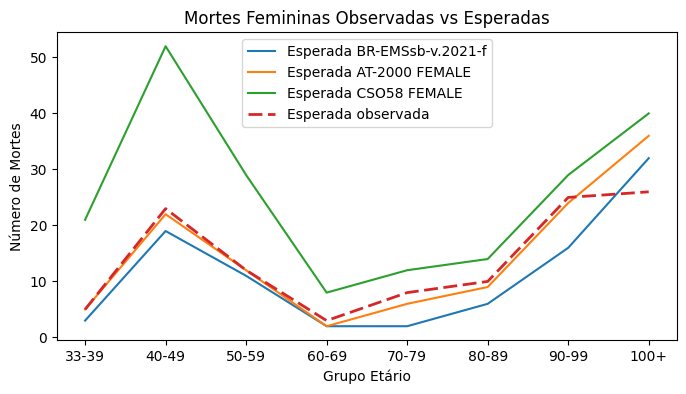

In [10]:
# Plotar os resultados para as mortes femininas
plt.figure(figsize=(8, 4))
for nome, tabua in zip(nomes_fem, tabuas_fem):
    esperada = agruparMortes(simularMortes(popuacaoFeminina, tabua))
    sns.lineplot(data=esperada, x='grupo_etario', y='dx', label=f'Esperada {nome}')
sns.lineplot(data=mortesFemininaObservada, x='grupo_etario', y='dx', label='Esperada observada', linewidth=2, dashes=(5, 2))
plt.title("Mortes Femininas Observadas vs Esperadas")
plt.xlabel("Grupo Etário")
plt.ylabel("Número de Mortes")
plt.show()

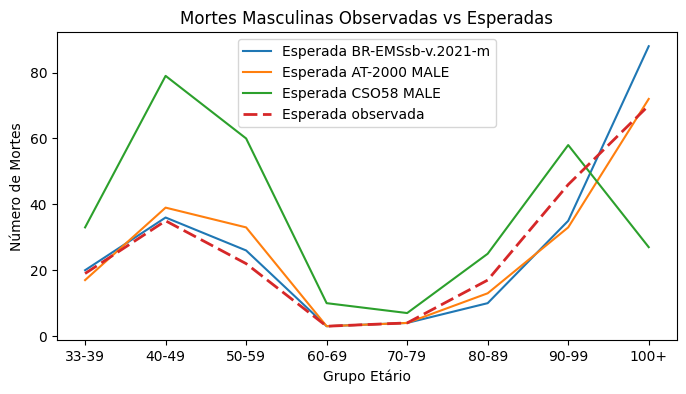

In [11]:
# Plotar os resultados para as mortes masculinas
plt.figure(figsize=(8, 4))
for nome, tabua in zip(nomes_mas, tabuas_mas):
    esperada = agruparMortes(simularMortes(populacaoMasculina, tabua))
    sns.lineplot(data=esperada, x='grupo_etario', y='dx', label=f'Esperada {nome}')
sns.lineplot(data=mortesMasculinaObservada, x='grupo_etario', y='dx', label='Esperada observada', linewidth=2, dashes=(5, 2))
plt.title("Mortes Masculinas Observadas vs Esperadas")
plt.xlabel("Grupo Etário")
plt.ylabel("Número de Mortes")
plt.show()